In [3]:
#cells will fill entire width of the browser
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

#Tells Jupyter to reload custom classes from scratch everytime an import cell is run, if you edit a custom class
#between imports Jupyter would otherwise need to be restarted completely. Buyer beware: old class objects in the 
#current namespace will cause errors at execution
%load_ext autoreload
%autoreload 2

#switches matplotlib to show plots in the browser rather than opening a new window
%matplotlib inline

#always forget to do this for better looking plots
import seaborn
seaborn.set()

In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import datetime
from cvxpy import *
from statsmodels.tsa import stattools
from sklearn import preprocessing
import random
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

/home/chase/applications/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
#In this notebook I'll load EPlus simulation output
#output the building's various components
#print each building's components to map which buildings to compare

In [4]:
class nnet(nn.Module):
    #linear model for kernelized inputs
    def __init__(self, params):
        super(nnet, self).__init__()
        self.D_in = params['FEATURE_DIM']
        self.D_out = params['OUTPUT_DIM']
        self.l1 = nn.Linear(self.D_in, self.D_out)
    
    def forward(self, x):
        x = self.l1(x) #linear weights for model interpretability
        return(x)

## EPlus

In [63]:
#features to ignore"
ignore = ["Performance Curve Input Variable 1 Value [] !Each Call", "Performance Curve Output Value [] !Each Call"]

#def parse_line()

def read_data_dictionary(lines):
    data_dict = {}
    for line in lines:
        l = line.strip()
        if l == "End of Data Dictionary":
            break
        else:
            tokens = l.split(",")
            if int(tokens[0]) == 2:
                data_dict[int(tokens[0])] = tokens[1:]
                #parse time dictionary line
            elif int(tokens[0]) > 6 and int(tokens[1]) == 1:
                if tokens[-1] in ignore:
                    pass
                elif len(tokens) == 4:
                    data_dict[int(tokens[0])] = tokens[-2] + tokens[-1]
                    
                else:
                    #parse value dictionary line
                    data_dict[int(tokens[0])] = tokens[-1]
            else:
                pass
    return(data_dict)

def parse_time_line(line_str):
    #2,8,Day of Simulation[],Month[],Day of Month[],DST Indicator[1=yes 0=no],Hour[],StartMinute[],EndMinute[],DayType
    #2, 1, 1, 1, 0, 1, 0.00, 2.00, Holiday
    #only want hourly times, multiple minute 2's, assuming got correct
    tokens = line_str.strip().split(",")
    minute=float(tokens[-3])
    hour=int(tokens[-4])
    day=int(tokens[-6])
    month=int(tokens[-7])
    return(datetime.datetime(2017, month, day, hour-1, 0, 0)) #2017 so that the 1st is a Sunday + not leapyear
    #return(str(month) + "/" + str(day) + " " + str(hour) + ":00")
     
def parse_lines(lines, feature_inds):
    data_values = {}
    data_values[2] = []
    for i in feature_inds:
        data_values[i] = []
    
    start_i = lines.index("End of Data Dictionary\n")
    for line in lines[start_i+1:-2]:
        tokens = line.strip().split(",")
        if int(tokens[0]) == 2:
            if float(tokens[-3]) == 0.00 and float(tokens[-2]) == 60.00:
                t = parse_time_line(line)
                data_values[2].append(t)
        elif int(tokens[0]) in feature_inds:
            data_values[int(tokens[0])].append(float(tokens[-1]))
        else:
            pass
    return(data_values)
    #return hourly list for all feature vars, plus hourly list with times to check sorting
    
def norm_array(arr):
    return(preprocessing.minmax_scale(arr, axis=1))

def read_total_data_array(filepath, dep_var_names, ind_var_names, zone_temp_inds):
    with open(datapath + filepath) as d:
        lines = d.readlines()
        lines.pop(0)
        data_dict = read_data_dictionary(lines)
        data = parse_lines(lines, data_dict)
        ind_map = {}
        for key, value in data_dict.items():
            if type(value) == list:
                value = value[-1]
            ind_map[value] = key

    X = np.zeros((len(dep_var_names) + len(zone_temp_inds), 8760))
    U = np.zeros((len(ind_var_names), 8760))

    for i in range(len(ind_var_names)):
        item = ind_var_names[i]
        ind = ind_map[item]
        if item == 'DayType':
            lis = data[ind]
            out = []
            for val in lis:
                out.append(val.weekday()/7.0)
            arr = np.array(out)
        else:
            arr = np.array(data[ind])
        U[i,:] = arr

    for j in range(len(dep_var_names)):
        item = dep_var_names[j]
        ind = ind_map[item]
        arr = np.array(data[ind])
        X[j,:] = arr

    for j in range(len(zone_temp_inds)):
        ind = zone_temp_inds[j]
        arr = np.array(data[ind])
        X[j+len(dep_var_names),:] = arr
        
    Z = np.vstack((X, U))
    return(Z, X, U)

def split_train_val(Z, X, U, shuff=True, split_prop=0.8):
    #order 1 model
    all_pairs = []
    for i in range(8759):
        all_pairs.append((Z[:,i], Z[0:-U.shape[0],i+1]))

    if shuff == True:
        random.shuffle(all_pairs) 
    else:
        pass

    train_pairs = all_pairs[0:int(split_prop*len(all_pairs))]
    val_pairs = all_pairs[-int((1.0-split_prop)*len(all_pairs)):]
    
    #normalize to training data
    X_train = []
    Y_train = []

    for item in train_pairs:
        X_train.append(item[0])
        Y_train.append(item[1])

    X_val = []
    Y_val = []
    for item in val_pairs:
        X_val.append(item[0])
        Y_val.append(item[1])

    X_train = np.asarray(X_train).T
    Y_train = np.asarray(Y_train).T

    X_val = np.asarray(X_val).T
    Y_val = np.asarray(Y_val).T
    
    return(X_train, Y_train, X_val, Y_val)

def normalize_data_set(X, Y, X_minmax_vals):
    X_norm = copy.copy(X)
    Y_norm = copy.copy(Y)
    
    for row in range(X.shape[0]):
        mx = np.max(X_minmax_vals[row,:])
        mn = np.min(X_minmax_vals[row,:])

        X_norm[row,:] = (1.0/(mx - mn))*(X[row,:] - mn)

        if row < Y.shape[0]:
            Y_norm[row,:] = (1.0/(mx - mn))*(Y[row,:] - mn)
            
    return(X_norm, Y_norm)

def polynomial_kernel_mat(X, poly_degree):
    X_poly = np.zeros((X.shape[0]*poly_degree,X.shape[1]))
    for d in range(poly_degree):
        for row in range(X.shape[0]):
            X_poly[row + d*poly_degree,:] = np.power(X[row,:], d)
    return(X_poly)

def prepare_data(Z, X, U, shuff=True, split_prop=0.8, normalizer=False, norm_mat=""):
    X_train_pre, Y_train_pre, X_val_pre, Y_val_pre = split_train_val(Z, X, U, shuff=shuff, split_prop=split_prop)

    if not normalizer:
        X_train, Y_train = normalize_data_set(X_train_pre, Y_train_pre, X_train_pre)
        X_val, Y_val = normalize_data_set(X_val_pre, Y_val_pre, X_train_pre)
    else:
        X_train, Y_train = normalize_data_set(X_train_pre, Y_train_pre, norm_mat)
        X_val, Y_val = normalize_data_set(X_val_pre, Y_val_pre, norm_mat)        

    X_train_poly = polynomial_kernel_mat(X_train, poly_degree)
    X_val_poly = polynomial_kernel_mat(X_val, poly_degree)
    
    return(X_train_poly, Y_train, X_val_poly, Y_val)

In [58]:
#global vars
datapath = "/home/chase/projects/building_transfer/data/eplus_sims/"

#shared simulation var names
dep_var_names = ['Electricity:Facility [J] !Hourly', 'Fans:Electricity [J] !Hourly', 'Cooling:Electricity [J] !Hourly']
ind_var_names = ['EnvironmentSite Outdoor Air Drybulb Temperature [C] !Hourly', 'EnvironmentSite Outdoor Air Relative Humidity [%] !Hourly', 'DayType']

poly_degree = 2

#simple order is just previous time step
ext_order = [0, 1, 9 , 10, 11, 17, 25]

#to test:
"""
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data[1922], lags=40, alpha=0.05)
plt.show()
"""

'\nfrom statsmodels.graphics.tsaplots import plot_pacf\nplot_pacf(data[1922], lags=40, alpha=0.05)\nplt.show()\n'

### Medium Office Building

In [64]:
#building specific var names
zone_temp_inds = [863,864,865]

Z, X, U = read_total_data_array("refbuild_med/seattle/RefBldgMediumOfficeNew2004_Chicago.eso", dep_var_names, ind_var_names, zone_temp_inds)

X_med_pre_norm = split_train_val(Z, X, U, shuff=True, split_prop=0.8)[0]

X_train_med_poly, Y_train_med, X_val_med_poly, Y_val_med = prepare_data(Z, X, U, shuff=True, split_prop=0.8)

#X_train_med_pre, Y_train_med_pre, X_val_med_pre, Y_val_med_pre = split_train_val(Z, X, U)

#X_train_med, Y_train_med = normalize_data_set(X_train_med_pre, Y_train_med_pre, X_train_med_pre)
#X_val_med, Y_val_med = normalize_data_set(X_val_med_pre, Y_val_med_pre, X_train_med_pre)

#X_train_med_poly = polynomial_kernel_mat(X_train_med, poly_degree)
#X_val_med_poly = polynomial_kernel_mat(X_val_med, poly_degree)

In [11]:
params = {'FEATURE_DIM': 9*poly_degree, 'OUTPUT_DIM': 6}
net = nnet(params)
loss_func = nn.SmoothL1Loss()#MSELoss()
optimizer = optim.SGD(net.parameters(),lr=0.005, momentum=0.9)
epochs = 1000
batch_size = 100

In [12]:
for e in range(epochs):
    print("Epoch: ", e)
    training_losses = []
    for k in range(int(X_train_med_poly.shape[1]/batch_size)):
        inp = Variable(torch.Tensor(X_train_med_poly[:,k*batch_size:(k+1)*batch_size].T))
        label = Variable(torch.Tensor(Y_train_med[:,k*batch_size:(k+1)*batch_size].T))
        
        out = net(inp)
        optimizer.zero_grad()
        loss = loss_func(out, label)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.data[0])
        
    print("Training loss: ", np.mean(training_losses))
    
    inp_val = Variable(torch.Tensor(X_val_med_poly.T))
    label_val = Variable(torch.Tensor(Y_val_med.T))
    out_val = net(inp_val)
    loss_val = loss_func(out_val, label_val)
    
    print("Validation loss:", loss_val)

Epoch:  0
Training loss:  0.05182071
Validation loss: tensor(0.0161, grad_fn=<SmoothL1LossBackward>)
Epoch:  1
Training loss:  0.0152680855
Validation loss: tensor(0.0145, grad_fn=<SmoothL1LossBackward>)
Epoch:  2
Training loss:  0.013864145
Validation loss: tensor(0.0132, grad_fn=<SmoothL1LossBackward>)
Epoch:  3
Training loss:  0.0126798265
Validation loss: tensor(0.0121, grad_fn=<SmoothL1LossBackward>)
Epoch:  4
Training loss:  0.011658488
Validation loss: tensor(0.0112, grad_fn=<SmoothL1LossBackward>)
Epoch:  5
Training loss:  0.010775749
Validation loss: tensor(0.0104, grad_fn=<SmoothL1LossBackward>)
Epoch:  6
Training loss:  0.010010913
Validation loss: tensor(0.0096, grad_fn=<SmoothL1LossBackward>)
Epoch:  7
Training loss:  0.0093465485
Validation loss: tensor(0.0090, grad_fn=<SmoothL1LossBackward>)
Epoch:  8
Training loss:  0.008767941
Validation loss: tensor(0.0085, grad_fn=<SmoothL1LossBackward>)
Epoch:  9
Training loss:  0.00826266
Validation loss: tensor(0.0080, grad_fn=<Sm

/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Training loss:  0.0067873085
Validation loss: tensor(0.0066, grad_fn=<SmoothL1LossBackward>)
Epoch:  14
Training loss:  0.006519653
Validation loss: tensor(0.0063, grad_fn=<SmoothL1LossBackward>)
Epoch:  15
Training loss:  0.0062818946
Validation loss: tensor(0.0061, grad_fn=<SmoothL1LossBackward>)
Epoch:  16
Training loss:  0.006070081
Validation loss: tensor(0.0059, grad_fn=<SmoothL1LossBackward>)
Epoch:  17
Training loss:  0.005880835
Validation loss: tensor(0.0057, grad_fn=<SmoothL1LossBackward>)
Epoch:  18
Training loss:  0.005711265
Validation loss: tensor(0.0056, grad_fn=<SmoothL1LossBackward>)
Epoch:  19
Training loss:  0.0055588945
Validation loss: tensor(0.0054, grad_fn=<SmoothL1LossBackward>)
Epoch:  20
Training loss:  0.0054215947
Validation loss: tensor(0.0053, grad_fn=<SmoothL1LossBackward>)
Epoch:  21
Training loss:  0.005297534
Validation loss: tensor(0.0052, grad_fn=<SmoothL1LossBackward>)
Epoch:  22
Training loss:  0.0051851296
Validation loss: tensor(0.0050, grad_fn=

Training loss:  0.0035301659
Validation loss: tensor(0.0034, grad_fn=<SmoothL1LossBackward>)
Epoch:  102
Training loss:  0.0035252231
Validation loss: tensor(0.0034, grad_fn=<SmoothL1LossBackward>)
Epoch:  103
Training loss:  0.0035203528
Validation loss: tensor(0.0034, grad_fn=<SmoothL1LossBackward>)
Epoch:  104
Training loss:  0.0035155527
Validation loss: tensor(0.0034, grad_fn=<SmoothL1LossBackward>)
Epoch:  105
Training loss:  0.0035108218
Validation loss: tensor(0.0034, grad_fn=<SmoothL1LossBackward>)
Epoch:  106
Training loss:  0.0035061587
Validation loss: tensor(0.0034, grad_fn=<SmoothL1LossBackward>)
Epoch:  107
Training loss:  0.0035015617
Validation loss: tensor(0.0034, grad_fn=<SmoothL1LossBackward>)
Epoch:  108
Training loss:  0.0034970294
Validation loss: tensor(0.0034, grad_fn=<SmoothL1LossBackward>)
Epoch:  109
Training loss:  0.0034925602
Validation loss: tensor(0.0034, grad_fn=<SmoothL1LossBackward>)
Epoch:  110
Training loss:  0.0034881523
Validation loss: tensor(0.

Training loss:  0.0032664475
Validation loss: tensor(0.0031, grad_fn=<SmoothL1LossBackward>)
Epoch:  189
Training loss:  0.0032646137
Validation loss: tensor(0.0031, grad_fn=<SmoothL1LossBackward>)
Epoch:  190
Training loss:  0.0032627964
Validation loss: tensor(0.0031, grad_fn=<SmoothL1LossBackward>)
Epoch:  191
Training loss:  0.0032609946
Validation loss: tensor(0.0031, grad_fn=<SmoothL1LossBackward>)
Epoch:  192
Training loss:  0.0032592095
Validation loss: tensor(0.0031, grad_fn=<SmoothL1LossBackward>)
Epoch:  193
Training loss:  0.00325744
Validation loss: tensor(0.0031, grad_fn=<SmoothL1LossBackward>)
Epoch:  194
Training loss:  0.003255686
Validation loss: tensor(0.0031, grad_fn=<SmoothL1LossBackward>)
Epoch:  195
Training loss:  0.003253947
Validation loss: tensor(0.0031, grad_fn=<SmoothL1LossBackward>)
Epoch:  196
Training loss:  0.0032522236
Validation loss: tensor(0.0031, grad_fn=<SmoothL1LossBackward>)
Epoch:  197
Training loss:  0.0032505149
Validation loss: tensor(0.0031

Training loss:  0.0031486116
Validation loss: tensor(0.0030, grad_fn=<SmoothL1LossBackward>)
Epoch:  279
Training loss:  0.0031476852
Validation loss: tensor(0.0030, grad_fn=<SmoothL1LossBackward>)
Epoch:  280
Training loss:  0.0031467655
Validation loss: tensor(0.0030, grad_fn=<SmoothL1LossBackward>)
Epoch:  281
Training loss:  0.0031458514
Validation loss: tensor(0.0030, grad_fn=<SmoothL1LossBackward>)
Epoch:  282
Training loss:  0.0031449434
Validation loss: tensor(0.0030, grad_fn=<SmoothL1LossBackward>)
Epoch:  283
Training loss:  0.0031440419
Validation loss: tensor(0.0030, grad_fn=<SmoothL1LossBackward>)
Epoch:  284
Training loss:  0.0031431448
Validation loss: tensor(0.0030, grad_fn=<SmoothL1LossBackward>)
Epoch:  285
Training loss:  0.0031422544
Validation loss: tensor(0.0030, grad_fn=<SmoothL1LossBackward>)
Epoch:  286
Training loss:  0.0031413694
Validation loss: tensor(0.0030, grad_fn=<SmoothL1LossBackward>)
Epoch:  287
Training loss:  0.0031404903
Validation loss: tensor(0.

Training loss:  0.0030848284
Validation loss: tensor(0.0030, grad_fn=<SmoothL1LossBackward>)
Epoch:  368
Training loss:  0.0030842805
Validation loss: tensor(0.0030, grad_fn=<SmoothL1LossBackward>)
Epoch:  369
Training loss:  0.0030837352
Validation loss: tensor(0.0030, grad_fn=<SmoothL1LossBackward>)
Epoch:  370
Training loss:  0.0030831934
Validation loss: tensor(0.0030, grad_fn=<SmoothL1LossBackward>)
Epoch:  371
Training loss:  0.0030826544
Validation loss: tensor(0.0030, grad_fn=<SmoothL1LossBackward>)
Epoch:  372
Training loss:  0.0030821185
Validation loss: tensor(0.0030, grad_fn=<SmoothL1LossBackward>)
Epoch:  373
Training loss:  0.0030815848
Validation loss: tensor(0.0030, grad_fn=<SmoothL1LossBackward>)
Epoch:  374
Training loss:  0.003081054
Validation loss: tensor(0.0030, grad_fn=<SmoothL1LossBackward>)
Epoch:  375
Training loss:  0.0030805261
Validation loss: tensor(0.0030, grad_fn=<SmoothL1LossBackward>)
Epoch:  376
Training loss:  0.0030800016
Validation loss: tensor(0.0

Training loss:  0.0030449186
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  459
Training loss:  0.003044572
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  460
Training loss:  0.003044227
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  461
Training loss:  0.0030438828
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  462
Training loss:  0.0030435412
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  463
Training loss:  0.0030432008
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  464
Training loss:  0.003042862
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  465
Training loss:  0.0030425244
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  466
Training loss:  0.0030421894
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  467
Training loss:  0.003041855
Validation loss: tensor(0.0029

Training loss:  0.0030192113
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  549
Training loss:  0.0030189785
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  550
Training loss:  0.0030187462
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  551
Training loss:  0.0030185147
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  552
Training loss:  0.0030182851
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  553
Training loss:  0.0030180558
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  554
Training loss:  0.0030178276
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  555
Training loss:  0.0030176006
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  556
Training loss:  0.003017374
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  557
Training loss:  0.0030171485
Validation loss: tensor(0.0

Training loss:  0.0030012387
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  641
Training loss:  0.0030010764
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  642
Training loss:  0.003000914
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  643
Training loss:  0.0030007528
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  644
Training loss:  0.0030005919
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  645
Training loss:  0.0030004317
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  646
Training loss:  0.0030002722
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  647
Training loss:  0.0030001134
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  648
Training loss:  0.002999955
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  649
Training loss:  0.0029997963
Validation loss: tensor(0.00

Training loss:  0.0029884416
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  733
Training loss:  0.002988324
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  734
Training loss:  0.0029882055
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  735
Training loss:  0.0029880882
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  736
Training loss:  0.0029879713
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  737
Training loss:  0.002987854
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  738
Training loss:  0.0029877378
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  739
Training loss:  0.0029876218
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  740
Training loss:  0.002987506
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  741
Training loss:  0.0029873902
Validation loss: tensor(0.002

Training loss:  0.0029787757
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  827
Training loss:  0.0029786862
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  828
Training loss:  0.0029785975
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  829
Training loss:  0.0029785093
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  830
Training loss:  0.0029784208
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  831
Training loss:  0.002978333
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  832
Training loss:  0.002978245
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  833
Training loss:  0.0029781577
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  834
Training loss:  0.00297807
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  835
Training loss:  0.002977983
Validation loss: tensor(0.0029,

Training loss:  0.0029713812
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  921
Training loss:  0.0029713118
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  922
Training loss:  0.0029712426
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  923
Training loss:  0.0029711735
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  924
Training loss:  0.0029711046
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  925
Training loss:  0.002971036
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  926
Training loss:  0.0029709674
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  927
Training loss:  0.0029708992
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  928
Training loss:  0.002970831
Validation loss: tensor(0.0029, grad_fn=<SmoothL1LossBackward>)
Epoch:  929
Training loss:  0.0029707632
Validation loss: tensor(0.00

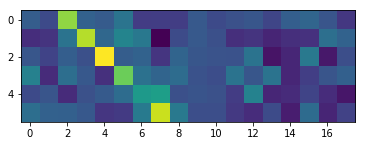

[[ 5.39370626e-02 -2.76531875e-02  7.02556670e-01  7.59583935e-02
   4.81042713e-02  1.65605113e-01 -8.33600536e-02 -8.14583600e-02
  -7.93928355e-02  3.55815813e-02 -2.71617565e-02  1.01621449e-03
   2.36058682e-02 -4.73556370e-02  6.24440163e-02  9.11878794e-02
   1.86363608e-02 -1.05365738e-01]
 [-1.41098261e-01 -1.17675468e-01  1.59155026e-01  7.69918144e-01
   1.01876438e-01  2.45220974e-01  1.82322890e-01 -2.98848093e-01
  -2.37536430e-02  3.64660285e-02 -6.52108062e-03 -1.37239382e-01
  -1.19550236e-01 -1.75328135e-01 -1.37541682e-01 -1.25458807e-01
   1.38326719e-01  7.78564960e-02]
 [ 2.03520451e-02 -5.60831241e-02  5.97521625e-02 -6.11774111e-03
   9.02406752e-01  5.37304729e-02  7.76684731e-02 -1.14237525e-01
   9.01171863e-02  2.40869522e-02  6.71468349e-03  4.19496000e-03
   1.60474315e-01 -2.35087901e-01 -1.71472147e-01  1.87515691e-01
  -2.23480344e-01 -8.72212648e-03]
 [ 2.29770929e-01 -1.51247859e-01  1.36148870e-01  3.15461494e-02
  -1.31082609e-01  6.33420050e-01  1.

In [35]:
A = net.l1.weight.data.numpy()
plt.imshow(net.l1.weight.data.numpy())
plt.show()
print(A)

In [46]:
np.mean(np.abs(label_val.detach().numpy() - out_val.detach().numpy()))

0.040011063

In [112]:
 #building specific var names
zone_temp_inds = [863,864,865]

Z_fault, X_fault, U_fault = read_total_data_array("refbuild_med_airfault/seattle/Fault_FoulingAirFilter_RefBldgMediumOfficeNew2004.eso", dep_var_names, ind_var_names, zone_temp_inds)

X_med_poly, Y_med = prepare_data(Z, X, U, shuff=False, split_prop=0.9)[0:2]
X_med_poly_fault, Y_med_fault = prepare_data(Z_fault, X_fault, U_fault, shuff=False, split_prop=0.9, normalizer=True, norm_mat=X_med_pre_norm)[0:2]

In [113]:
e_lkhds = []
e_lkhds_fault = []

f_lkhds = []
f_lkhds_fault = []

for i in range(X_med_poly.shape[1]-1):  #arbitrary time of year
    e_lkhds.append(np.power(A.dot(X_med_poly[:,i]) - Y_med[:,i],2)[0])
    e_lkhds_fault.append(np.power(A.dot(X_med_poly_fault[:,i]) - Y_med_fault[:,i],2)[0])
    
    f_lkhds.append(np.power(A.dot(X_med_poly[:,i]) - Y_med[:,i],2)[1])
    f_lkhds_fault.append(np.power(A.dot(X_med_poly_fault[:,i]) - Y_med_fault[:,i],2)[1])

In [114]:

print(np.mean(e_lkhds), np.mean(e_lkhds_fault))
print(np.mean(f_lkhds), np.mean(f_lkhds_fault))

0.0058448817574342435 0.005908579155113443
0.04473207542521652 0.04737665575396145


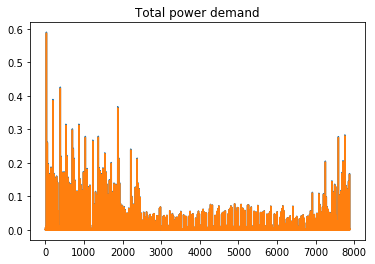

In [115]:
plt.title("Total power demand")
plt.plot(e_lkhds_fault)
plt.plot(e_lkhds)
plt.show()

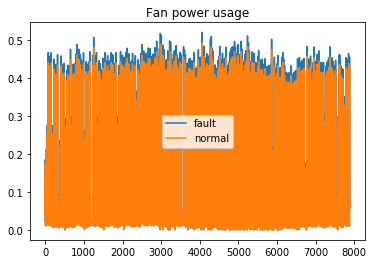

In [116]:
plt.title("Fan power usage")
plt.plot(f_lkhds_fault, label="fault")
plt.plot(f_lkhds, label="normal")
plt.legend()
plt.show()

In [117]:
 #building specific var names
zone_temp_inds = [863,864,865]

Z_fault_deg, X_fault_deg, U_fault_deg = read_total_data_array("refbuild_med_airfaultdeg/seattle/Fault_FoulingAirFilter_RefBldgMediumOfficeNew2004.eso", dep_var_names, ind_var_names, zone_temp_inds)

X_med_poly, Y_med = prepare_data(Z, X, U, shuff=False, split_prop=0.9)[0:2]
X_med_poly_fault, Y_med_fault = prepare_data(Z_fault_deg, X_fault_deg, U_fault_deg, shuff=False, split_prop=0.9, normalizer=True, norm_mat=X_med_pre_norm)[0:2]

In [118]:
e_lkhds = []
e_lkhds_fault = []

f_lkhds = []
f_lkhds_fault = []

for i in range(X_med_poly.shape[1]-1):  #arbitrary time of year
    e_lkhds.append(np.power(A.dot(X_med_poly[:,i]) - Y_med[:,i],2)[0])
    e_lkhds_fault.append(np.power(A.dot(X_med_poly_fault[:,i]) - Y_med_fault[:,i],2)[0])
    
    f_lkhds.append(np.power(A.dot(X_med_poly[:,i]) - Y_med[:,i],2)[1])
    f_lkhds_fault.append(np.power(A.dot(X_med_poly_fault[:,i]) - Y_med_fault[:,i],2)[1])

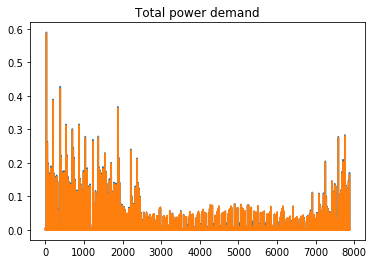

In [119]:
plt.title("Total power demand")
plt.plot(e_lkhds_fault)
plt.plot(e_lkhds)
plt.show()

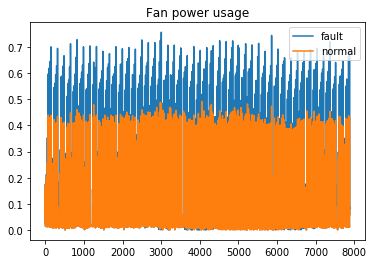

In [120]:
plt.title("Fan power usage")
plt.plot(f_lkhds_fault, label="fault")
plt.plot(f_lkhds, label="normal")
plt.legend()
plt.show()

In [121]:
print(np.mean(e_lkhds), np.mean(e_lkhds_fault))
print(np.mean(f_lkhds), np.mean(f_lkhds_fault))

0.0058448817574342435 0.005879069818676576
0.04473207542521652 0.061714946660199256


In [124]:
 #building specific var names
zone_temp_inds = [863,864,865]

Z_fault_p, X_fault_p, U_fault_p = read_total_data_array("refbuild_med/phoenix/Static_RefBldgMediumOfficeNew2004_Chicago.eso", dep_var_names, ind_var_names, zone_temp_inds)

X_med_poly, Y_med = prepare_data(Z, X, U, shuff=False, split_prop=0.9)[0:2]
X_med_poly_fault, Y_med_fault = prepare_data(Z_fault_p, X_fault_p, U_fault_p, shuff=False, split_prop=0.9, normalizer=True, norm_mat=X_med_pre_norm)[0:2]

In [125]:
e_lkhds = []
e_lkhds_fault = []

f_lkhds = []
f_lkhds_fault = []

for i in range(X_med_poly.shape[1]-1):  #arbitrary time of year
    e_lkhds.append(np.power(A.dot(X_med_poly[:,i]) - Y_med[:,i],2)[0])
    e_lkhds_fault.append(np.power(A.dot(X_med_poly_fault[:,i]) - Y_med_fault[:,i],2)[0])
    
    f_lkhds.append(np.power(A.dot(X_med_poly[:,i]) - Y_med[:,i],2)[1])
    f_lkhds_fault.append(np.power(A.dot(X_med_poly_fault[:,i]) - Y_med_fault[:,i],2)[1])

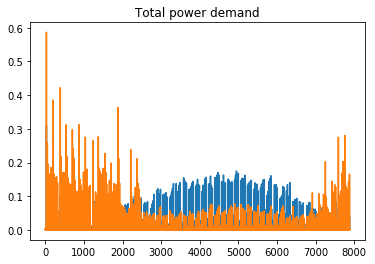

In [126]:
plt.title("Total power demand")
plt.plot(e_lkhds_fault)
plt.plot(e_lkhds)
plt.show()

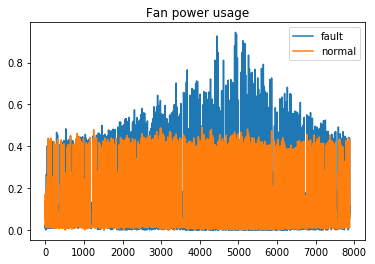

In [127]:
plt.title("Fan power usage")
plt.plot(f_lkhds_fault, label="fault")
plt.plot(f_lkhds, label="normal")
plt.legend()
plt.show()

In [128]:
print(np.mean(e_lkhds), np.mean(e_lkhds_fault))
print(np.mean(f_lkhds), np.mean(f_lkhds_fault))

0.0058448817574342435 0.008127863317464677
0.04473207542521652 0.06772614739149231


In [ ]:
#performance against identity
#number of samples to converge matrix
# --- control for temperature seasonality
# --- remove weekends holidays
# --- diferencing for stationary

# --- two ways to transfer: either bundle components or for unknown components set to 0 and bootstrap with blocks of known columns

### Rescaling is not enough

In [129]:
#building specific var names
zone_temp_inds = [863,864,865]

Z_fault_p, X_fault_p, U_fault_p = read_total_data_array("refbuild_med/phoenix/Static_RefBldgMediumOfficeNew2004_Chicago.eso", dep_var_names, ind_var_names, zone_temp_inds)

X_med_poly, Y_med = prepare_data(Z, X, U, shuff=False, split_prop=0.9)[0:2]
X_med_poly_fault, Y_med_fault = prepare_data(Z_fault_p, X_fault_p, U_fault_p, shuff=False, split_prop=0.9, normalizer=False)[0:2]

In [130]:
e_lkhds = []
e_lkhds_fault = []

f_lkhds = []
f_lkhds_fault = []

for i in range(X_med_poly.shape[1]-1):  #arbitrary time of year
    e_lkhds.append(np.power(A.dot(X_med_poly[:,i]) - Y_med[:,i],2)[0])
    e_lkhds_fault.append(np.power(A.dot(X_med_poly_fault[:,i]) - Y_med_fault[:,i],2)[0])
    
    f_lkhds.append(np.power(A.dot(X_med_poly[:,i]) - Y_med[:,i],2)[1])
    f_lkhds_fault.append(np.power(A.dot(X_med_poly_fault[:,i]) - Y_med_fault[:,i],2)[1])

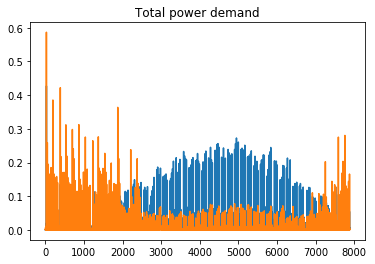

In [131]:
plt.title("Total power demand")
plt.plot(e_lkhds_fault)
plt.plot(e_lkhds)
plt.show()

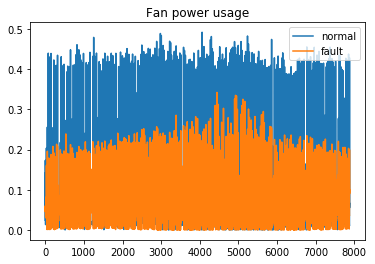

In [133]:
plt.title("Fan power usage")
plt.plot(f_lkhds, label="normal")
plt.plot(f_lkhds_fault, label="fault")
plt.legend()
plt.show()

### Retrain for phoenix

In [134]:
#params = {'FEATURE_DIM': 9*poly_degree, 'OUTPUT_DIM': 6}
#net = nnet(params)
#loss_func = nn.SmoothL1Loss()#MSELoss()
#optimizer = optim.SGD(net.parameters(),lr=0.005, momentum=0.9)
epochs = 100
batch_size = 10

In [139]:
Z_p, X_p, U_p = read_total_data_array("refbuild_med/phoenix/Static_RefBldgMediumOfficeNew2004_Chicago.eso", dep_var_names, ind_var_names, zone_temp_inds)

X_med_pre_norm_p = split_train_val(Z_p, X_p, U_p, shuff=True, split_prop=0.2)[0]

X_train_med_poly_p, Y_train_med_p, X_val_med_poly_p, Y_val_med_p = prepare_data(Z_p, X_p, U_p, shuff=True, split_prop=0.2)

In [140]:
for e in range(epochs):
    print("Epoch: ", e)
    training_losses = []
    for k in range(int(X_train_med_poly_p.shape[1]/batch_size)):
        inp = Variable(torch.Tensor(X_train_med_poly_p[:,k*batch_size:(k+1)*batch_size].T))
        label = Variable(torch.Tensor(Y_train_med_p[:,k*batch_size:(k+1)*batch_size].T))
        
        out = net(inp)
        optimizer.zero_grad()
        loss = loss_func(out, label)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.data[0])
        
    print("Training loss: ", np.mean(training_losses))
    
    #no validation data available
    #inp_val = Variable(torch.Tensor(X_val_med_poly.T))
    #label_val = Variable(torch.Tensor(Y_val_med.T))
    #out_val = net(inp_val)
    #loss_val = loss_func(out_val, label_val)
    
    #print("Validation loss:", loss_val)

Epoch:  0
Training loss:  0.002789081
Epoch:  1
Training loss:  0.0027843872
Epoch:  2
Training loss:  0.0027812722
Epoch:  3
Training loss:  0.0027785439
Epoch:  4
Training loss:  0.0027761005
Epoch:  5
Training loss:  0.0027738763
Epoch:  6
Training loss:  0.0027718262
Epoch:  7
Training loss:  0.0027699196
Epoch:  8
Training loss:  0.0027681342
Epoch:  9


/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Training loss:  0.0027664534
Epoch:  10
Training loss:  0.0027648646
Epoch:  11
Training loss:  0.0027633565
Epoch:  12
Training loss:  0.0027619225
Epoch:  13
Training loss:  0.002760554
Epoch:  14
Training loss:  0.0027592462
Epoch:  15
Training loss:  0.0027579928
Epoch:  16
Training loss:  0.0027567905
Epoch:  17
Training loss:  0.0027556345
Epoch:  18
Training loss:  0.0027545213
Epoch:  19
Training loss:  0.002753448
Epoch:  20
Training loss:  0.0027524123
Epoch:  21
Training loss:  0.0027514107
Epoch:  22
Training loss:  0.002750441
Epoch:  23
Training loss:  0.002749502
Epoch:  24
Training loss:  0.002748591
Epoch:  25
Training loss:  0.0027477061
Epoch:  26
Training loss:  0.0027468463
Epoch:  27
Training loss:  0.0027460102
Epoch:  28
Training loss:  0.0027451958
Epoch:  29
Training loss:  0.002744403
Epoch:  30
Training loss:  0.002743629
Epoch:  31
Training loss:  0.0027428742
Epoch:  32
Training loss:  0.0027421373
Epoch:  33
Training loss:  0.0027414171
Epoch:  34
Trainin

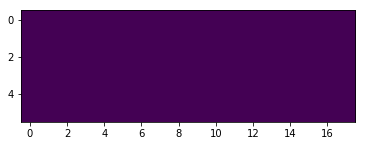

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [141]:
A_t = net.l1.weight.data.numpy()
A_diff = A_t - A
plt.imshow(A_diff)
plt.show()
print(A_diff)

### Large Office Building

In [ ]:
#building specific var names
zone_temp_inds = [889,890,891]

with open(datapath + "refbuild_largeoffice/seattle/RefBldgLargeOfficeNew2004_Chicago.eso") as d:
    lines = d.readlines()
    lines.pop(0)
    data_dict = read_data_dictionary(lines)
    data = parse_lines(lines, data_dict)
    ind_map = {}
    for key, value in data_dict.items():
        if type(value) == list:
            value = value[-1]
        ind_map[value] = key
    
X = np.zeros((len(dep_var_names) + 3, 8760))
U = np.zeros((len(ind_var_names), 8760))
    
for i in range(len(ind_var_names)):
    item = ind_var_names[i]
    ind = ind_map[item]
    if item == 'DayType':
        lis = data[ind]
        out = []
        for val in lis:
            out.append(val.weekday()/7.0)
        arr = np.array(out)
    else:
        arr = np.array(data[ind])
    U[i,:] = arr
    
for j in range(len(dep_var_names)):
    item = dep_var_names[j]
    ind = ind_map[item]
    arr = np.array(data[ind])
    X[j,:] = arr
    
for j in range(3):
    ind = zone_temp_inds[j]
    arr = np.array(data[ind])
    X[j+len(dep_var_names),:] = arr

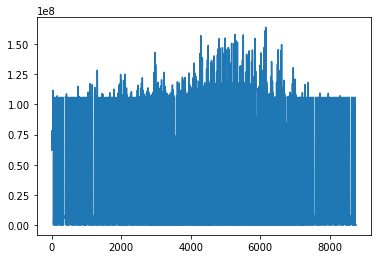

In [68]:
plt.plot(data[2051])
plt.show()

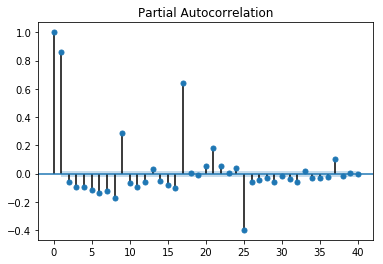

In [69]:
plot_pacf(data[2051], lags=40, alpha=0.05)
plt.show()

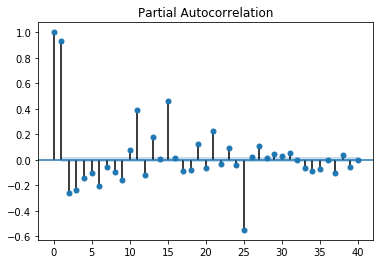

In [70]:
plot_pacf(data[12], lags=40, alpha=0.05)
plt.show()

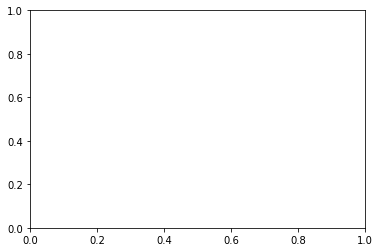

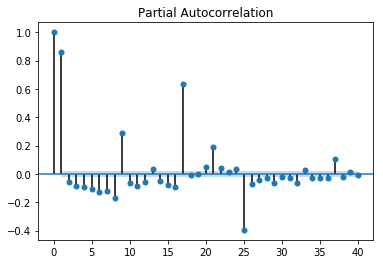

In [72]:
plot_pacf(data[3042], lags=40, alpha=0.05)
plt.show()

## SEB

In [39]:
def read_file_timestamp(strin):
    out = datetime.datetime.strptime(strin, '%Y-%m-%dT%H:%M:%S')
    return(out)

def file_name_from_timestamp(dtobj):
    out = datetime.datetime.strftime(dtobj, "%Y-%m-%d")
    return(out)

def read_volttron_file(fobj, col=1):
    p = []
    lines = fobj.readlines()
    lines.pop(0)
    for line in lines:
        p.append(float(line.strip().split(",")[col]))
    return(p)

def utc_offset(data_list):
    first = data_list[0:480]
    last = data_list[480:]
    return(last + first)

def to_celsius(fah):
    c = (fah - 32.0)/1.8
    return(c)

def norm_array(arr):
    return(preprocessing.minmax_scale(arr, axis=1))

def mean_minute_blocks(arr, minutes):
    output = []
    for i in range(int(len(arr)/minutes)):
        output.append(np.mean(arr[i*minutes:(i+1)*minutes]))
    return(output)

filedates = []
for i in range(21,27): #day 27 is missing data
    filedates.append(file_name_from_timestamp(datetime.datetime(year=2018, month=6, day=i)))
    
weekend = [2,3]
weekdays = [0,1,4,5]

#SEB_months = ["March", "April", "May", "June", "July", "August", "September", "October"]
SEB_months = ["June"]

In [51]:
datadir = "/home/chase/projects/buildnn/data/PNNL/SEB/"

powerdata = []
file_lengths = []

for m in SEB_months:
    csv_files = os.listdir(datadir + "/" + m + "/ELECTRIC_METER/WholeBuildingDemand/")
    for f in csv_files:
        p = []
        with open(datadir + "/" + m + "/ELECTRIC_METER/WholeBuildingDemand/" + f, "r") as d:
            lines = d.readlines()
            file_lengths.append(len(lines))
            lines.pop(0)
            for line in lines:
                p.append(float(line.strip().split(",")[1]))
            powerdata.append(p)

powerdata = np.asarray(powerdata)

In [52]:
powerdata.shape

(30, 1439)

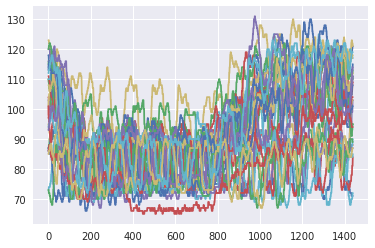

In [54]:
plt.plot(powerdata.T)
plt.show()

In [61]:
airunits = ["AHU1", "AHU2", "AHU3", "AHU4"]
airvars = ["ExhaustFanPower", "OutdoorAirTemperature", "SupplyFanPower"]
vavvars = ["ZoneCoolingTemperatureSetPoint", "ZoneTemperature", "ZoneHeatingTemperatureSetPoint"]

ahudata = {}
vavdata = {}

for M in SEB_months:
    for a in airunits:
        ahudata[a] = {}
        msrmnts = os.listdir(datadir + M + "/" + a)
        for m in msrmnts:
            if m in airvars:
                ahudata[a][m] = []
                filedates = os.listdir(datadir + M + "/" + a + "/" + m + "/")
                for f in filedates:
                    with open(datadir + M + "/" + a + "/" + m + "/" + f, 'r') as d:
                        ahudata[a][m].append(utc_offset(read_volttron_file(d)))
            if m[0:3] == "VAV" and (m[-1] != "A" and m[-1] != "B" and m[-1] != "S" and m[-1] != "Y"):
                vavdata[m] = {}
                for v in vavvars:
                    vavdata[m][v] = []
                    filedates = os.listdir(datadir + M + "/" + a + "/" + m + "/" + v)
                    for f in filedates:
                        with open(datadir + M + "/" + a + "/" + m + "/" + v + "/" + f, 'r') as d:
                            vavdata[m][v].append(utc_offset(read_volttron_file(d)))

        for m in ahudata[a]:
            ahudata[a][m] = np.asarray(ahudata[a][m])

        for v in vavdata:
            for mv in vavdata[v]:
                vavdata[v][mv] = np.asarray(vavdata[v][mv])

In [59]:
filedates

['MaximumZoneAirFlow',
 'ZoneReheatAirFlow',
 'MinimumZoneAirFlow',
 'DeviceOverrideCooling']